In [1]:
import os.path as op
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import torch
import torch.nn as nn
import hnn_core
from hnn_core import calcium_model, simulate_dipole, read_params, pick_connection
from hnn_core.network_models import add_erp_drives_to_jones_model
from hnn_core.network_builder import NetworkBuilder
from hnn_core.cell import _get_gaussian_connection
from sklearn.model_selection import ShuffleSplit
from sklearn.linear_model import LinearRegression
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import utils
from utils import (SingleNeuron_Data, Network_Data, CellType_Dataset_Fast, model_network,
                   linear_scale_forward, log_scale_forward, UniformPrior, beta_tuning_param_function)
import multiprocessing
from typing import Dict, Tuple, Optional, List
import dill

device = torch.device("cuda:0")
# device = 'cpu'
num_cores = multiprocessing.cpu_count()
torch.backends.cudnn.enabled = True

In [2]:
# Set up prior distribution
prior_dict = {'EI_gscale': {'bounds': (-3, 3), 'rescale_function': log_scale_forward},
              'EE_gscale': {'bounds': (-3, 0), 'rescale_function': log_scale_forward},
              'II_gscale': {'bounds': (-3, 3), 'rescale_function': log_scale_forward},
              'IE_gscale': {'bounds': (-3, 3), 'rescale_function': log_scale_forward},
              'EI_prob': {'bounds': (0.5, 1), 'rescale_function': linear_scale_forward},
              'EE_prob': {'bounds': (0.5, 1), 'rescale_function': linear_scale_forward},
              'II_prob': {'bounds': (0.5, 1), 'rescale_function': linear_scale_forward},
              'IE_prob': {'bounds': (0.5, 1), 'rescale_function': linear_scale_forward},
              'L2e_distal': {'bounds': (-4, -1), 'rescale_function': log_scale_forward},
              'L2i_distal': {'bounds': (-4, -1), 'rescale_function': log_scale_forward},
              'L5e_distal': {'bounds': (-4, -1), 'rescale_function': log_scale_forward},
              'L5i_distal': {'bounds': (-4, -1), 'rescale_function': log_scale_forward},
              'L2e_proximal': {'bounds': (-4, -1), 'rescale_function': log_scale_forward},
              'L2i_proximal': {'bounds': (-4, -1), 'rescale_function': log_scale_forward},
              'L5e_proximal': {'bounds': (-4, -1), 'rescale_function': log_scale_forward},
              'L5i_proximal': {'bounds': (-4, -1), 'rescale_function': log_scale_forward},
              }


prior = UniformPrior(parameters=list(prior_dict.keys()))
dt = 0.5

In [3]:
# Instiatiate network and collect connectivity data

hnn_core_root = op.dirname(hnn_core.__file__)
params_fname = op.join(hnn_core_root, 'param', 'default.json')
params = read_params(params_fname)
params.update({'N_pyr_x': 7, 'N_pyr_y': 7})

net = calcium_model(params)


# Extract all E-I connection types
E_gids = np.concatenate([net.gid_ranges['L2_pyramidal'], net.gid_ranges['L5_pyramidal']]).tolist()
I_gids = np.concatenate([net.gid_ranges['L2_basket'], net.gid_ranges['L5_basket']]).tolist()

EI_connections = pick_connection(net, src_gids=E_gids, target_gids=I_gids)
EE_connections = pick_connection(net, src_gids=E_gids, target_gids=E_gids)
II_connections = pick_connection(net, src_gids=I_gids, target_gids=I_gids)
IE_connections = pick_connection(net, src_gids=I_gids, target_gids=E_gids)

# Store in dictionary to be added to theta_dict
theta_extra = {'EI_connections': EI_connections, 'EE_connections': EE_connections, 
               'II_connections': II_connections, 'IE_connections': IE_connections,
               'lamtha': 4.0}
theta_extra['sample_idx'] =  0

# Update network parameters
thetai = torch.tensor(np.repeat(0.6, len(prior_dict)))
theta_dict = {param_name: param_dict['rescale_function'](thetai[param_idx].numpy(), param_dict['bounds']) for 
                param_idx, (param_name, param_dict) in enumerate(prior_dict.items())}

theta_dict['theta_extra'] = theta_extra

theta_dict['EI_prob'] = 0.8
theta_dict['EE_prob'] = 0.8
theta_dict['IE_prob'] = 0.8
theta_dict['II_prob'] = 0.8

# # theta_dict['IE_gscale'] = 10
# # theta_dict['EI_gscale'] = 10
# # theta_dict['EE_gscale'] = 10
# # theta_dict['II_gscale'] = 10

theta_dict['L2i_distal'] = 1.0
theta_dict['L2i_proximal'] = 1.0
theta_dict['L5i_distal'] = 1.0
theta_dict['L5i_proximal'] = 1.0
theta_dict['L5e_proximal'] = 1.0
theta_dict['L5e_proximal'] = 1.0
theta_dict['L5e_distal'] = 1.0
theta_dict['L5e_distal'] = 1.0


beta_tuning_param_function(net, theta_dict, rate=10)

In [4]:
%%capture
net_drive = net.copy()
net_drive.clear_connectivity()
net_connectivity = net.copy()
_ = simulate_dipole(net_drive, dt=dt, tstop=1000, record_vsec='all', record_isec='all', record_dcell=True)
_ = simulate_dipole(net_connectivity, dt=dt, tstop=1, record_vsec='all', record_isec='all', record_dcell=True)

network_data_drive = Network_Data(net_drive, soma_filter=True)
network_data_connectivity = Network_Data(net_connectivity, soma_filter=True)

In [5]:
dataset_type = 'connected'
dataset_indices = [0]

model_architecture = {'L5_pyramidal': {'hidden_dim': 64, 'n_layers': 5},
                      'L2_pyramidal': {'hidden_dim': 64, 'n_layers': 5},
                      'L5_basket': {'hidden_dim': 8, 'n_layers': 2},
                      'L2_basket': {'hidden_dim': 8, 'n_layers': 2}}

model_dict, dataset_dict = dict(), dict()
for cell_type in net.cell_types:
    cell_type_dataset = torch.utils.data.ConcatDataset(
        [torch.load(f'datasets_{dataset_type}/training_data/{cell_type}_dataset_{idx}.pt') for
         idx in dataset_indices])
    dataset_dict[cell_type] = cell_type_dataset

    _, input_size = cell_type_dataset[0][0].detach().cpu().numpy().shape
    _, output_size = cell_type_dataset[0][1].detach().cpu().numpy().shape

    model_dict[cell_type] = utils.model_celltype_lstm(
        input_size=input_size, output_size=output_size, device=device, **model_architecture[cell_type])
    # model_dict[cell_type] = torch.jit.script(utils.model_celltype_lstm(
    #     input_size=input_size, output_size=output_size, device=device, **model_architecture[cell_type]))
    model_dict[cell_type].load_state_dict(torch.load(f'{dataset_type}_models/{cell_type}_{dataset_type}_model.pt'))
    model_dict[cell_type].to(device)

In [6]:
model_pytorch = model_network(net, model_dict, dataset_dict, network_data_connectivity, device=device, bidirectional=False)
# model = torch.jit.script(model_pytorch).to(device)
model = model_pytorch.to(device)

# Make input spike dict initialized with prox/distal noisy drive
input_spike_dict = dict()
for cell_type in net.cell_types:
    gid_list = net.gid_ranges[cell_type]
    input_spike_dict[cell_type] = torch.from_numpy(
        np.stack([network_data_drive.input_spike_dict[gid].T for gid in gid_list])).float()[:, :600, :].to(device)


lr = 1.0
weight_decay = 0.0
optimizer = torch.optim.Adam(model.EI_dict.parameters(), lr=lr, weight_decay=weight_decay)

In [7]:
print_freq = 1

max_epochs = 10

EI_dict_list = [np.array([val.clone().cpu().item() for val in model.EI_dict.values()])]
losses = list()
for epoch in range(max_epochs):
    model.train()
    optimizer.zero_grad()
    # input_spikes = input_spike_dict.clone().to(device).requires_grad_(False)

    pred_y = model(input_spike_dict['L5_pyramidal'].clone(), input_spike_dict['L2_pyramidal'].clone(),
                    input_spike_dict['L5_basket'].clone(), input_spike_dict['L2_basket'].clone())


    # dpl = pred_y[1][:,:,-1].mean(axis=1) + pred_y[3][:,:,-1].mean(axis=1)
    # dpl = pred_y[1][:,:,-1].mean(axis=1)
    dpl = pred_y[3][:,:,-1].mean(axis=1)

    out_fft = torch.fft.rfft(dpl).abs() ** 2
    freq = torch.fft.rfftfreq(pred_y[1].size(0), dt / 1e3)


    power = torch.sum(out_fft[torch.logical_and(freq > 6, freq < 12)])
    # denom = torch.sum(out_fft[torch.logical_and(freq < 30, freq > 0)]) + torch.sum(out_fft[torch.logical_and(freq < 100, freq > 40)])

    relative_power = - power

    relative_power.backward()
    optimizer.step()

    losses.append(relative_power.item())

    #Print Loss Scores
    if (epoch+1)%print_freq == 0:
        print('')
        print('Epoch: {}/{} ...'.format(epoch+1, max_epochs), end=' ')
        print('Relative Power: {:.4f}'.format(-relative_power))

    else:
        print('*', end='')

    EI_vals = np.array([val.clone().cpu().item() for val in model.EI_dict.values()])
    EI_dict_list.append(EI_vals)



Epoch: 1/10 ... Relative Power: 213387.7188

Epoch: 2/10 ... Relative Power: 330998.4375

Epoch: 3/10 ... Relative Power: 6229594.5000

Epoch: 4/10 ... Relative Power: 7440479.0000

Epoch: 5/10 ... Relative Power: 6748309.0000

Epoch: 6/10 ... Relative Power: 8077036.0000

Epoch: 7/10 ... Relative Power: 6477918.5000

Epoch: 8/10 ... Relative Power: 7339855.5000

Epoch: 9/10 ... Relative Power: 7376620.0000

Epoch: 10/10 ... Relative Power: 8799050.0000


Text(0.5, 15.0, 'Epoch')

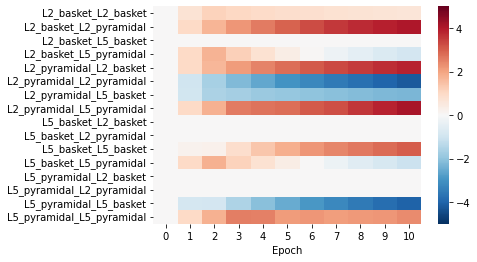

In [8]:
EI_array = np.array(EI_dict_list)
df = pd.DataFrame(EI_array, columns=model.EI_dict.keys())
# _ = plt.plot(EI_array)
sns.heatmap(df.T, cmap='RdBu_r', center=0, vmin=-5, vmax=5)
plt.xlabel('Epoch')

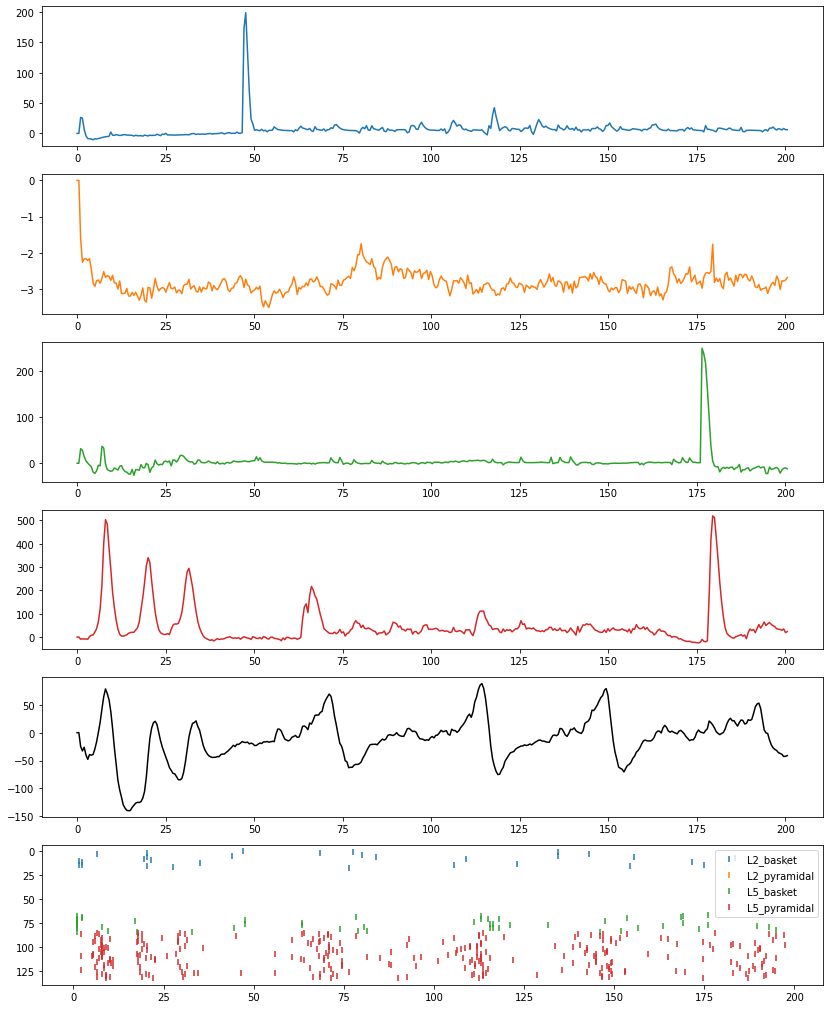

In [9]:
plt.figure(figsize=(14, 18))
for idx, cell_type in enumerate(['L2_basket', 'L2_pyramidal', 'L5_basket', 'L5_pyramidal']):
    out = pred_y[idx][:,:,0].detach().cpu().numpy()

    plt.subplot(6, 1, idx+1)
    pred_trace = out[:,0]
    plt.plot(np.linspace(0, pred_trace.size * 0.5, pred_trace.size), pred_trace, c=f'C{idx}', label=cell_type)

    threshold = model.threshold_dict[cell_type].detach().cpu().numpy()

    cell_spikes = (out > threshold) & (np.roll(out, 1, axis=0) < threshold)
    cell_spike_indices = np.where(cell_spikes > 0)
    offset =  list(net.gid_ranges[cell_type])[0]

    plt.subplot(6, 1, 6)
    plt.scatter(cell_spike_indices[0] * 0.5, cell_spike_indices[1] + offset, c=f'C{idx}', marker='|', label=cell_type)

plt.subplot(6,1,5)
dpl_trace = dpl.detach().cpu().numpy()
plt.plot(np.linspace(0, dpl_trace.size * 0.5, dpl_trace.size), dpl_trace, c='k', label='dpl')

plt.subplot(6,1,6)
plt.gca().invert_yaxis()
plt.legend()
    

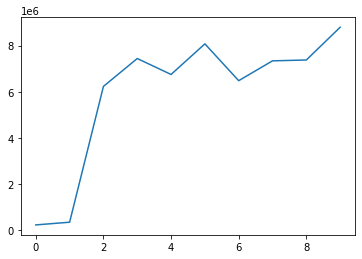

In [10]:
plt.plot(-np.array(losses))
# plt.xlim(0,30)

Text(0, 0.5, 'Power')

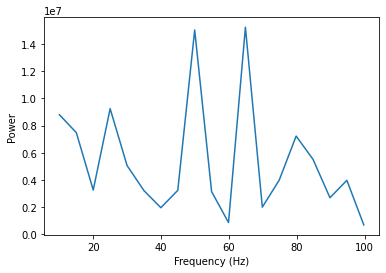

In [11]:
mask = np.logical_and(freq > 5, freq < 100).numpy().astype(bool)
plt.plot(freq.detach().cpu().numpy()[mask], out_fft.detach().cpu().numpy()[mask])
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power')

In [18]:
# Make input spike dict initialized with prox/distal noisy drive
input_spike_dict = dict()
for cell_type in net.cell_types:
    gid_list = net.gid_ranges[cell_type]
    input_spike_dict[cell_type] = torch.from_numpy(
        np.stack([network_data_drive.input_spike_dict[gid].T for gid in gid_list])).float()[:, :, :].to(device)

plot_epoch = 0
for key in df.columns:
    model.EI_dict[key] = torch.tensor(df[key].values[plot_epoch]).to(device)

with torch.no_grad():
    model.train()
    # model.eval()
    pred_y = model(input_spike_dict['L5_pyramidal'].clone(), input_spike_dict['L2_pyramidal'].clone(),
                    input_spike_dict['L5_basket'].clone(), input_spike_dict['L2_basket'].clone())

dpl = pred_y[1][:,:,1].mean(axis=1) + pred_y[3][:,:,1].mean(axis=1)
dpl_l2 = pred_y[1][:,:,1].mean(axis=1)
dpl_l5 = pred_y[3][:,:,1].mean(axis=1)

out_fft = torch.fft.rfft(dpl).abs() ** 2
out_fft_l2 = torch.fft.rfft(dpl_l2).abs() ** 2
out_fft_l5 = torch.fft.rfft(dpl_l5).abs() ** 2

freq = torch.fft.rfftfreq(pred_y[1].size(0), dt / 1e3)

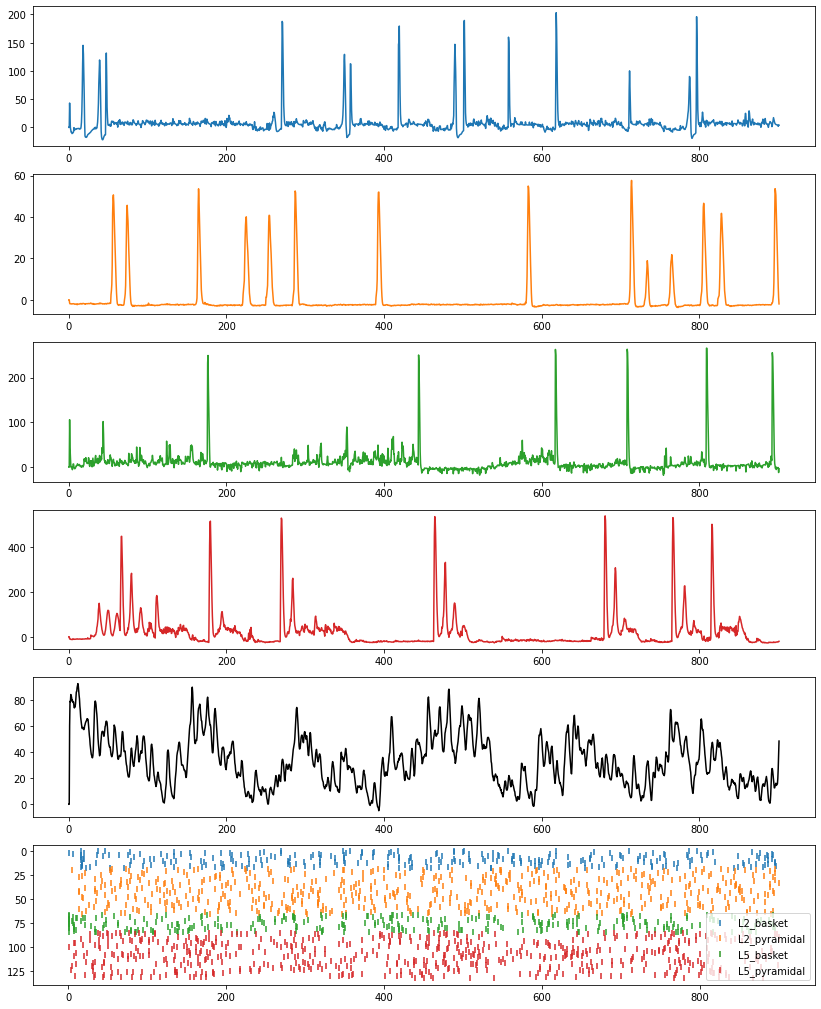

In [19]:
plt.figure(figsize=(14, 18))
for idx, cell_type in enumerate(['L2_basket', 'L2_pyramidal', 'L5_basket', 'L5_pyramidal']):
    out = pred_y[idx][:,:,0].detach().cpu().numpy()

    plt.subplot(6, 1, idx+1)
    pred_trace = out[:,0]
    plt.plot(np.linspace(0, pred_trace.size * 0.5, pred_trace.size), pred_trace, c=f'C{idx}', label=cell_type)

    threshold = model.threshold_dict[cell_type].detach().cpu().numpy()

    cell_spikes = (out > threshold) & (np.roll(out, 1, axis=0) < threshold)
    cell_spike_indices = np.where(cell_spikes > 0)
    offset =  list(net.gid_ranges[cell_type])[0]

    plt.subplot(6, 1, 6)
    plt.scatter(cell_spike_indices[0] * 0.5, cell_spike_indices[1] + offset, c=f'C{idx}', marker='|', label=cell_type)

plt.subplot(6,1,5)
dpl_trace = dpl.detach().cpu().numpy()
plt.plot(np.linspace(0, dpl_trace.size * 0.5, dpl_trace.size), dpl_trace, c='k', label='dpl')

plt.subplot(6,1,6)
plt.gca().invert_yaxis()
plt.legend()
    

Text(0, 0.5, 'Power')

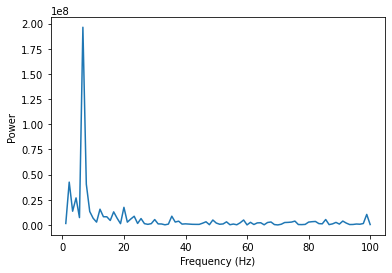

In [20]:
mask = np.logical_and(freq > 0, freq < 100).numpy().astype(bool)
# plt.plot(freq.detach().cpu().numpy()[mask], out_fft_l2.detach().cpu().numpy()[mask])
plt.plot(freq.detach().cpu().numpy()[mask], out_fft_l5.detach().cpu().numpy()[mask])

plt.xlabel('Frequency (Hz)')
plt.ylabel('Power')
# plt.xlim(0,40)


In [15]:
optim_res = {
    'losses': losses,
    'EI_array': EI_array,
    'EI_dict_keys': list(model.EI_dict.keys()),
    'prior_dict': prior_dict,
    'theta_dict': theta_dict, # Initial values of parameters
    'dt': dt,
    'net_drive': net_drive,
    'net_connectivity': net_connectivity,
}

In [16]:
with open(f'surrogate_plot_data/lowfreq_optim_res_v2.pkl', 'wb') as f:
    dill.dump(optim_res, f)